## Grab multiple gliders in a bounding box and over a period of time using ERDDAPY

## Grab glider data from IOOS DAC using ERDDAPY


This tutorial shows you how to navigate the [IOOS glider DAC](https://gliders.ioos.us/erddap/index.html) webpage and download multiple glider data using ERDDAPY in a csv format.

More advanced tutorials can be found on the [IOOS CodeLab](https://ioos.github.io/ioos_code_lab/content/intro.html) and the [ERDDAPY](https://ioos.github.io/erddapy/01b-tabledap-output.html) Github pages.

Navigate to https://gliders.ioos.us/erddap/index.html and then to the "Advanced Search" page to view all glider deployments based on keywords, bounding box, or time constraint.

![ERDDAP_HOMEPAGE](assets/erddap_homepage2.png)

Once you navigate to the advanced search page, there are options to search for all deployments that have a similar keyword, variables,institution, etc.

In this example, we will yous the "Search for Datasets that have Data within Longitude, Latitude, and Time Ranges" option.

Input your min, max longitude and latitude values and time range. This example looks at a bounding box of [-100, -80, 15, 30] starting at 2025-05-15 to today. You can see that there are 8 deployments that fit in this criteria.

You can download each deployment invidually by navigating to their respective data pages.

![ERDDAP_ADVANCED_SEARCH](assets/erddap_advanced_search_page.png)

## ERDDAPY

The rest of this tutorial will focus on using ERDDAPY to grab multiple glider deployments in a similar fashion as the advanced search and stuff it into a pandas dataframe.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from erddapy import ERDDAP
import cmocean
import cool_maps.plot as cplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from collections import namedtuple
import datetime as dt
from pprint import pprint
import multiprocessing
from gsw import SA_from_SP, CT_from_t, rho, p_from_z

This function is a python version of the advanced search and takes the same criteria - a bounding box (min lon, max lon, min lat, max lat) and a time range

In [2]:
def get_active_gliders(bbox=None, t0=None, t1=dt.date.today(), variables=None, 
                       timeout=5, parallel=False,var_search=None):
    variables = variables or ['time', 'latitude', 'longitude','depth','temperature','salinity']
    bbox = bbox or [-100, -40, 18, 60]
    t0 = t0 or (t1 - dt.timedelta(days=1))

    # Convert dates to strings
    t0 = t0.strftime('%Y-%m-%dT%H:%M:%SZ')
    t1 = t1.strftime('%Y-%m-%dT%H:%M:%SZ')

    # Initialize GliderDAC Object
    # e = ERDDAP(server='NGDAC')
    e = ERDDAP(server="https://gliders.ioos.us/erddap")
    
    

    # Set timeout (seconds)
    e.requests_kwargs['timeout'] = timeout

    # Grab every dataset available
    # Search constraints
    kw = dict()
    kw['min_time'] = t0
    kw['max_time'] = t1

    if bbox:
        kw['min_lon'] = bbox[0]
        kw['max_lon'] = bbox[1]
        kw['min_lat'] = bbox[2]
        kw['max_lat'] = bbox[3]

    search_url = e.get_search_url(search_for=var_search, response='csv', **kw)

    try:
        # Grab the results
        search = pd.read_csv(search_url)
    except uHTTPError as error:
        print(f"{inspect.currentframe().f_code.co_name} - Error: {error}")
        # return empty dataframe if there are no results
        return pd.DataFrame()
    except URLError as e:
        print(f"{inspect.currentframe().f_code.co_name} - Error: {error}")
        # return empty dataframe if there are no results
        return pd.DataFrame()

    # Extract the IDs
    gliders = search['Dataset ID'].values

    msg = f"Found {len(gliders)} Glider Datasets: "
    pprint(msg + ', '.join(gliders.tolist()))

    # Setting constraints
    constraints = {
            'time>=': t0,
            'time<=': t1,
            # 'longitude>=': bbox[0],
            # 'longitude<=': bbox[1],
            # 'latitude>=': bbox[2],
            # 'latitude<=': bbox[3],
            }
    dfn=pd.DataFrame({'gliders':gliders})
    
    def request_multi(dataset_id, protocol="tabledap", variables=None):
   
        e.constraints = constraints
        e.protocol = protocol
        # e.variables = ['time', 'latitude', 'longitude']
        e.variables = variables
        e.dataset_id = dataset_id
        print(dataset_id)
        
        # Drop units in the first line and Nans
        
        df = e.to_pandas(
            response="csv", 
            index_col="time",
            parse_dates=True,
            skiprows=(1,)
            ).dropna().tz_localize(None)
        return (dataset_id, df)
    dfs = {glider: df for (glider, df) in [request_multi(id,variables=variables) for id in dfn.gliders.values]}
    df = pd.concat(dfs)
    return df

We will using a bounding box of [-100, -80, 15, 30] and a time range of the last five days to retrieve multiple gliders.

In [3]:


# get data
Glider = namedtuple('Glider', ['name', 'lon', 'lat'])
time_formatter = '%Y-%m-%dT%H:%M:%SZ'

rename_gliders = {}
# rename_gliders["time (UTC)"] = "time"
rename_gliders["longitude"] = "lon"
rename_gliders["latitude"] = "lat"


bbox=[-100,-81,15,30]

t0 = dt.datetime.today() - dt.timedelta(days=5)

t1 =  dt.datetime.today()
var_search=None
# variables=['time','latitude','longitude','profile_id']
variables = ['time', 'latitude', 'longitude','depth','temperature','salinity']
gdf=get_active_gliders(bbox=bbox, t0=t0,t1=t1, variables=variables, 
                       timeout=5, parallel=False,var_search=None)

('Found 7 Glider Datasets: mote-holly-20250429T0000, OSU266-20250307T0000, '
 'ru38-20250414T1500, sg622-20250514T0000, sg651-20250428T0000, '
 'unit_308-20250414T0000, usf-jaialai-20250515T0000')
mote-holly-20250429T0000
OSU266-20250307T0000
ru38-20250414T1500
sg622-20250514T0000
sg651-20250428T0000
unit_308-20250414T0000
usf-jaialai-20250515T0000


In [4]:
gdf = gdf.reset_index()
gdf = gdf.rename(columns={'level_0': 'glider'})
gdf

,glider,time,latitude,longitude,depth,temperature,salinity
0,mote-holly-20250429T0000,2025-05-15 10:12:56,26.793232,-82.963892,5.370374,26.2610,36.181236
1,mote-holly-20250429T0000,2025-05-15 10:12:56,26.793232,-82.963892,6.764032,26.1158,36.202490
2,mote-holly-20250429T0000,2025-05-15 10:12:56,26.793232,-82.963892,8.104434,26.0762,36.213116
3,mote-holly-20250429T0000,2025-05-15 10:12:56,26.793232,-82.963892,9.442641,26.0499,36.204453
4,mote-holly-20250429T0000,2025-05-15 10:12:56,26.793232,-82.963892,10.782430,26.0312,36.215300
...,...,...,...,...,...,...,...
231036,usf-jaialai-20250515T0000,2025-05-20 09:52:32,27.954485,-83.987200,6.369491,25.5694,35.957123
231037,usf-jaialai-20250515T0000,2025-05-20 09:52:36,27.954489,-83.987204,3.797561,25.5888,35.907112
231038,usf-jaialai-20250515T0000,2025-05-20 09:52:36,27.954489,-83.987204,4.592526,25.6102,35.896748
231039,usf-jaialai-20250515T0000,2025-05-20 09:52:36,27.954489,-83.987204,6.369491,25.5694,35.957123


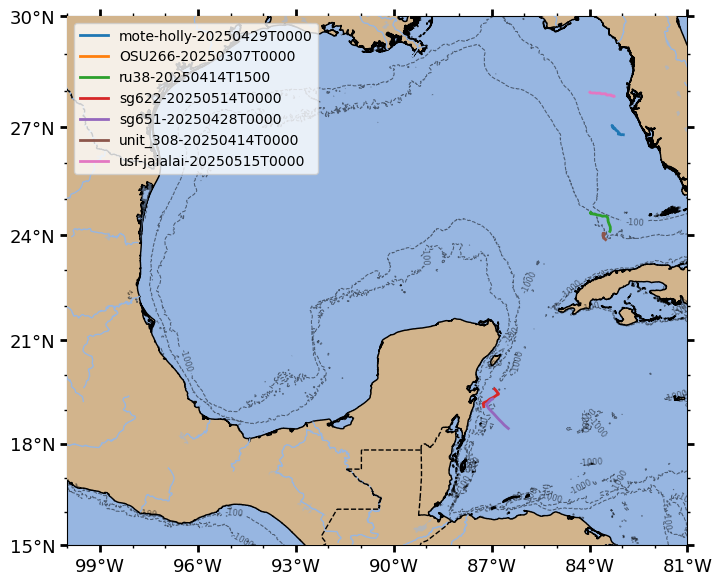

In [5]:
## plot a map of the glider tracks

extent=[-100, -81, 15, 30]

fig,ax= plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs.Mercator()})

#use cool maps to create cartopy map
cplt.create(extent,ax=ax, proj=ccrs.Mercator(),gridlines=False, bathymetry=True)


gidx = gdf.glider.unique()

for i, glider in enumerate(gidx):
    glider_df = gdf[gdf['glider'] == glider]
    
    ax.plot(glider_df['longitude'], glider_df['latitude'],lw=2, label=glider,transform=ccrs.PlateCarree(),zorder=10000)
    
ax.legend(loc='upper left', fontsize=10).set_zorder(1000)

Because it isn't standard which for of density is submitted to the DAC, lets calculate the density for each deployment

In [6]:
def density(temperature, depth, salinity, latitude, longitude):
    """
    Calculates density given practical salinity, depth, latitude,
    and longitude using Gibbs gsw SA_from_SP and rho functions.
    Args:
        temperature (_type_): temperature (C)
        depth (_type_): depth, positive up (m)
        salinity (array): salinity
        latitude (array): latitude (decimal degrees)
        longitude (array): longitude (decimal degrees)
    Returns:
        density: Density calculated using the Gibbs GSW
    """

    # Calculates sea pressure from height using computationally-efficient 
    # 75-term expression for density, in terms of SA, CT and p 
    # (Roquet et al., 2015). 
    pressure = p_from_z(
        depth,
        latitude,
    )

    # Calculates Absolute Salinity from Practical Salinity. 
    # Since SP is non-negative by definition,
    # this function changes any negative input values of SP to be zero.
    absolute_salinity = SA_from_SP(
        salinity,
        pressure,
        longitude,
        latitude
    )

    # Calculates Conservative Temperature of seawater from in-situ temperature.
    conservative_temperature = CT_from_t(
        absolute_salinity,
        temperature,
        pressure
    )

    # Calculates in-situ density from Absolute Salinity and
    # Conservative Temperature, using the computationally-efficient expression 
    # for specific volume in terms of SA, CT and p (Roquet et al., 2015).
    density = rho(
        absolute_salinity,
        conservative_temperature,
        pressure
    )

    return density

def process_group(pdf):
    pdf['density'] = density(
        pdf['temperature'].values, 
        -pdf['depth'].values, 
        pdf['salinity'].values, 
        pdf['latitude'].values, 
        pdf['longitude'].values
    )
    return pdf

In [7]:
# here we group by glider and time, where time is unique to an individual profile
gdf = gdf.groupby(['glider','time'], group_keys=False).apply(process_group)
gdf

,glider,time,latitude,longitude,depth,temperature,salinity,density
0,mote-holly-20250429T0000,2025-05-15 10:12:56,26.793232,-82.963892,5.370374,26.2610,36.181236,1023.867211
1,mote-holly-20250429T0000,2025-05-15 10:12:56,26.793232,-82.963892,6.764032,26.1158,36.202490,1023.935030
2,mote-holly-20250429T0000,2025-05-15 10:12:56,26.793232,-82.963892,8.104434,26.0762,36.213116,1023.961294
3,mote-holly-20250429T0000,2025-05-15 10:12:56,26.793232,-82.963892,9.442641,26.0499,36.204453,1023.968808
4,mote-holly-20250429T0000,2025-05-15 10:12:56,26.793232,-82.963892,10.782430,26.0312,36.215300,1023.988657
...,...,...,...,...,...,...,...,...
231036,usf-jaialai-20250515T0000,2025-05-20 09:52:32,27.954485,-83.987200,6.369491,25.5694,35.957123,1023.918799
231037,usf-jaialai-20250515T0000,2025-05-20 09:52:36,27.954489,-83.987204,3.797561,25.5888,35.907112,1023.863897
231038,usf-jaialai-20250515T0000,2025-05-20 09:52:36,27.954489,-83.987204,4.592526,25.6102,35.896748,1023.852872
231039,usf-jaialai-20250515T0000,2025-05-20 09:52:36,27.954489,-83.987204,6.369491,25.5694,35.957123,1023.918799


In [8]:
## check how many days of data we retrieved for each deployment
gdf['time'] = pd.to_datetime(gdf['time'])

# Get list of unique gliders
gliders = gdf['glider'].unique()

for gg in gliders:
    print(gg)
    test = gdf[gdf.glider == gg]
    t1 = test.time.max()
    t0 = test.time.min()
    print(t1-t0)

mote-holly-20250429T0000
4 days 21:32:50
OSU266-20250307T0000
4 days 17:55:12
ru38-20250414T1500
4 days 22:31:06
sg622-20250514T0000
4 days 12:32:38
sg651-20250428T0000
4 days 20:15:00
unit_308-20250414T0000
4 days 17:30:30
usf-jaialai-20250515T0000
4 days 20:07:34


Lets plot the upper 200m of temperature, salinity, and density profiles for each deployment

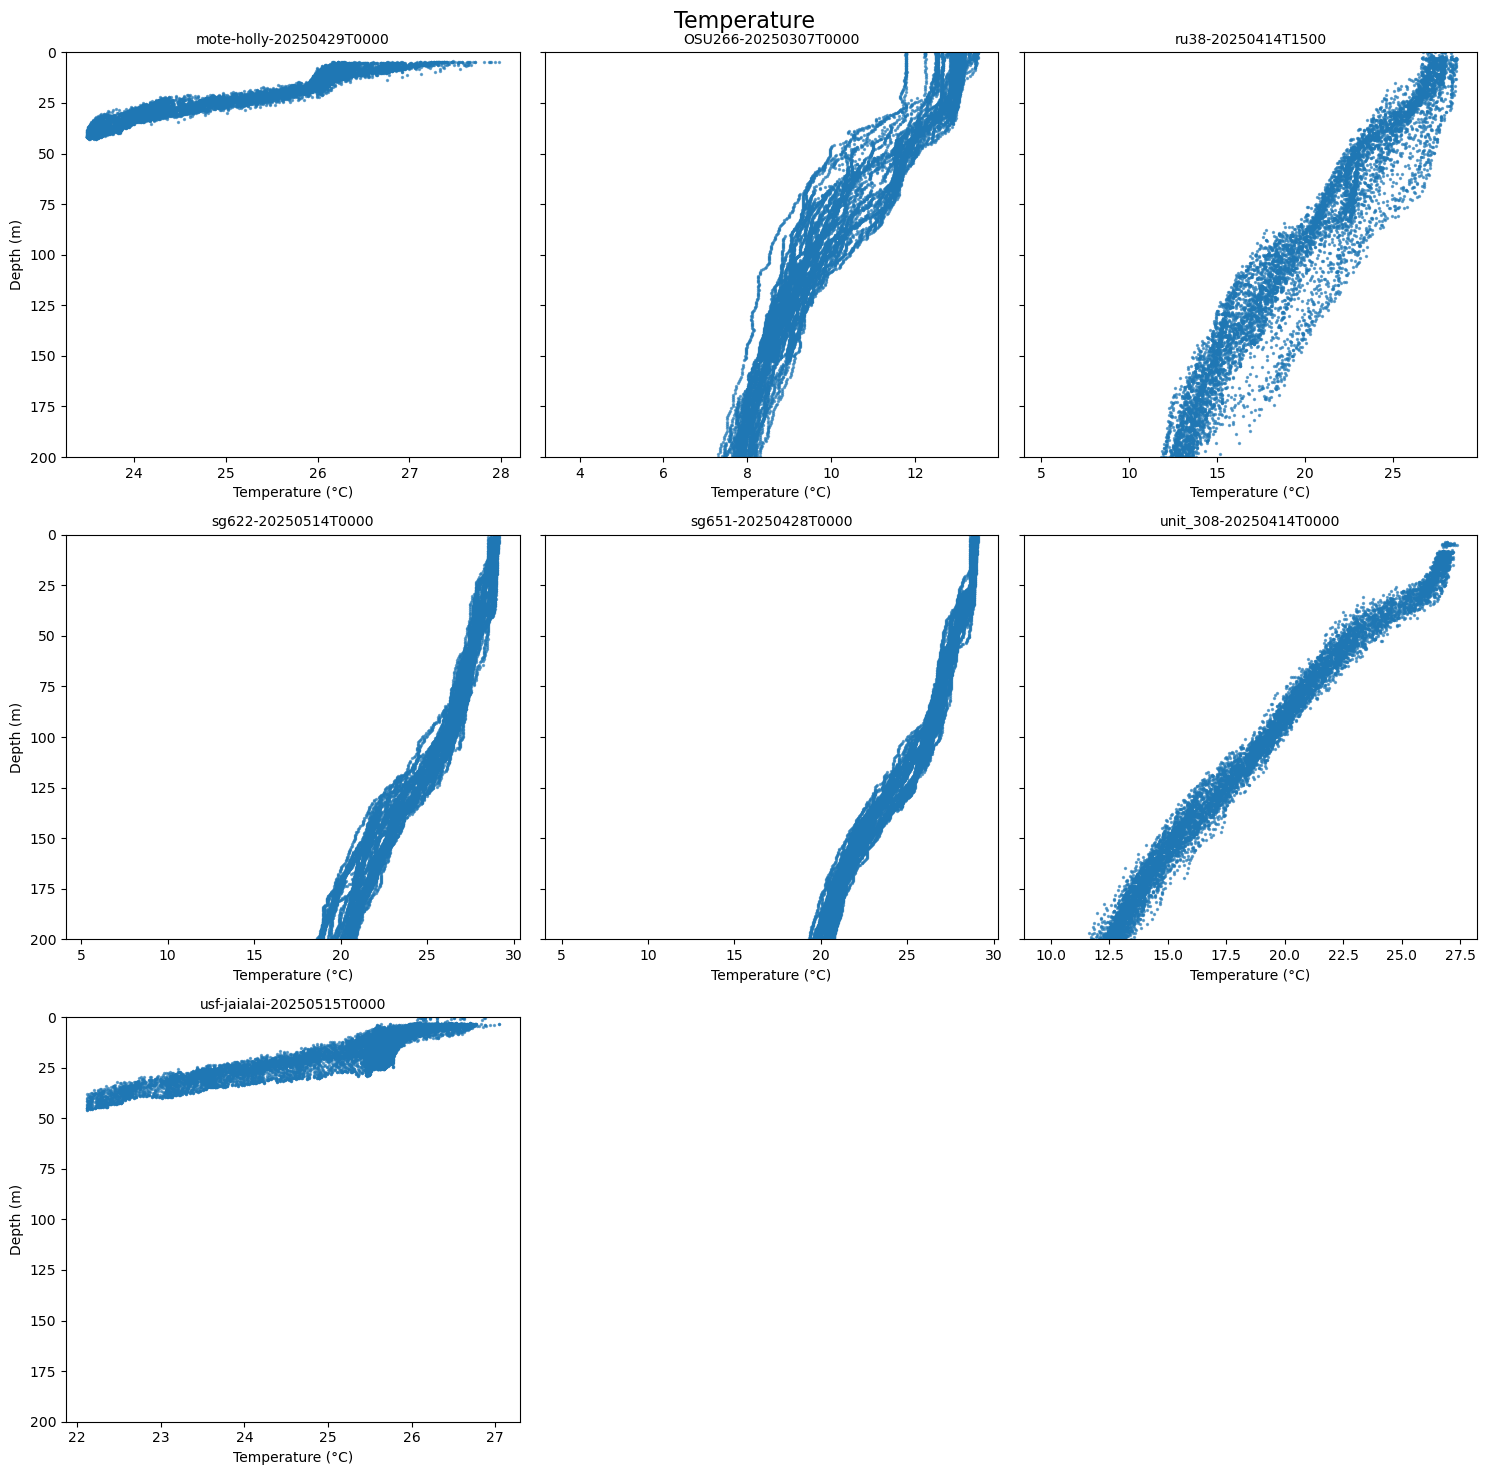

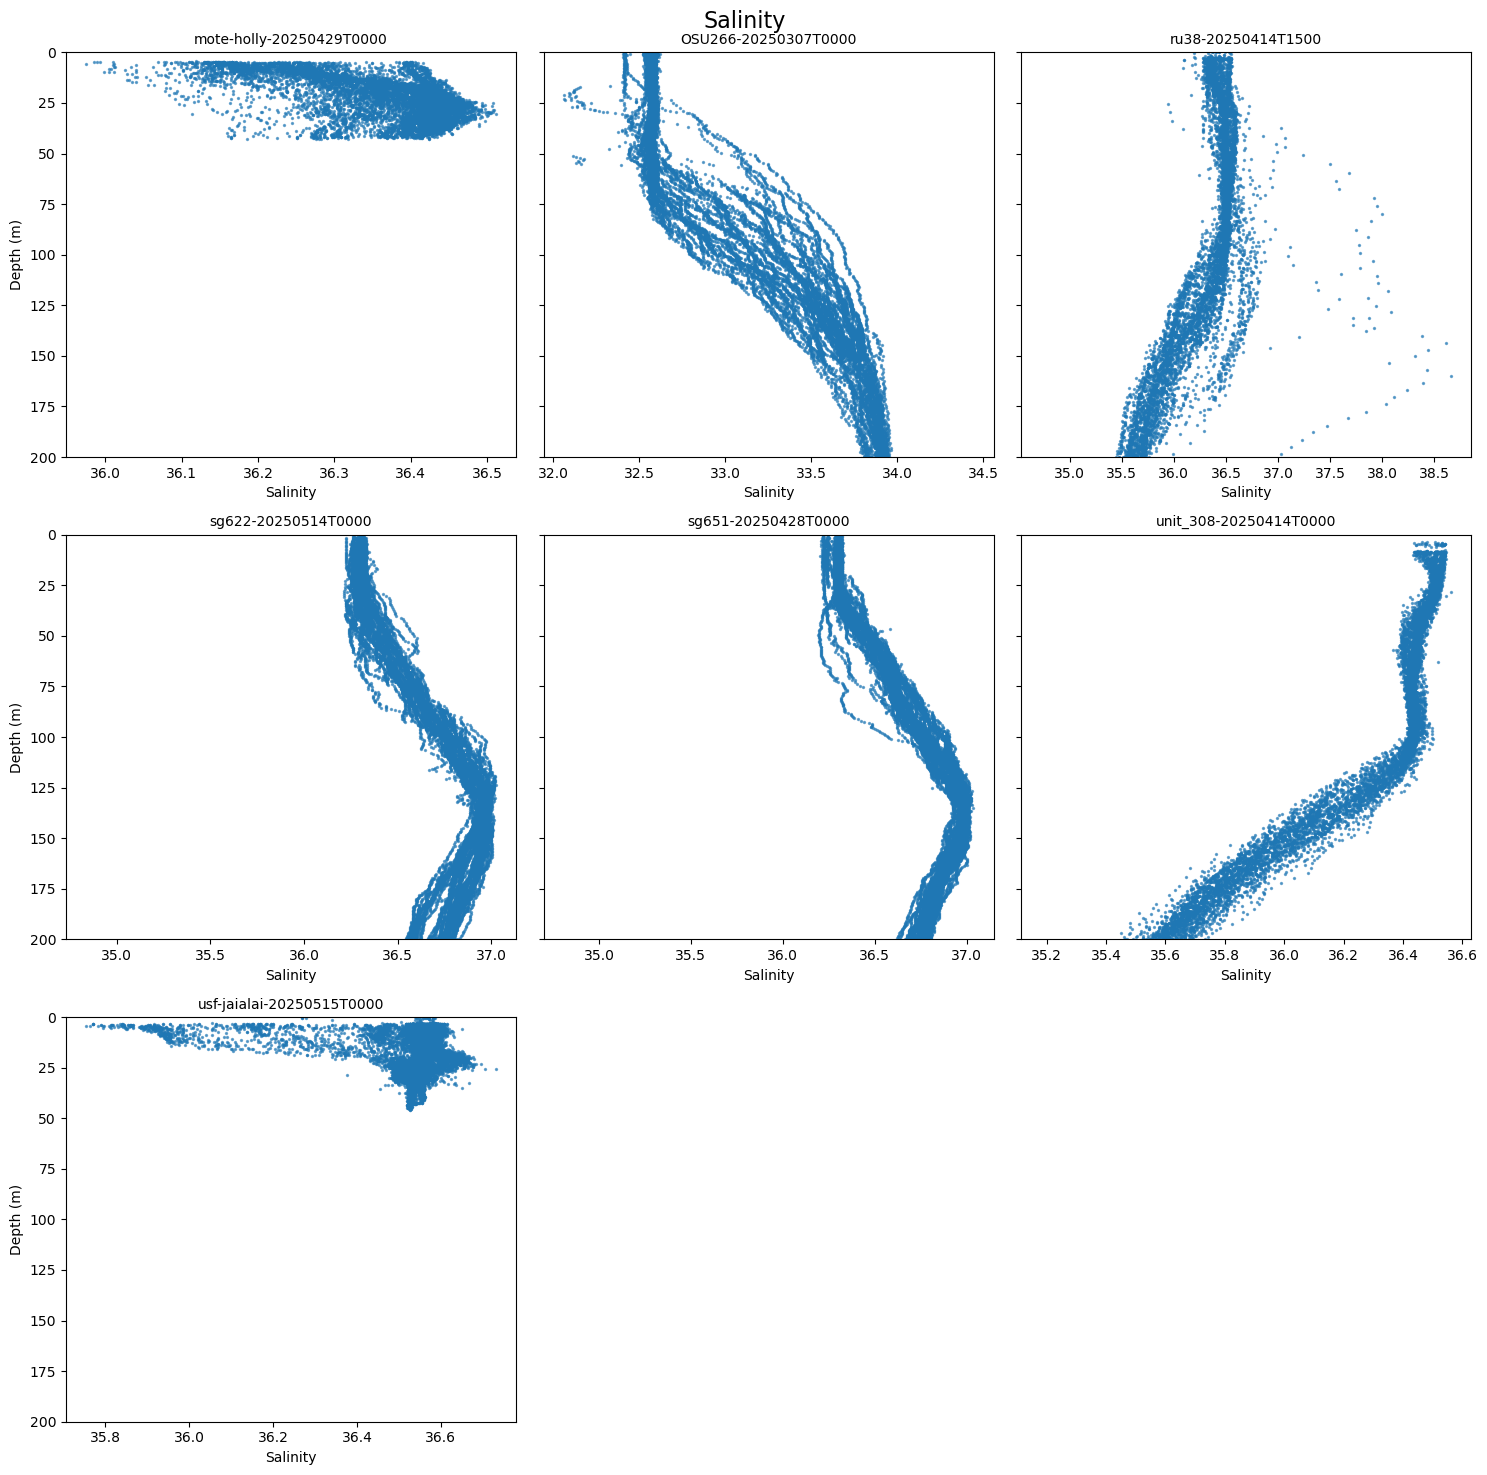

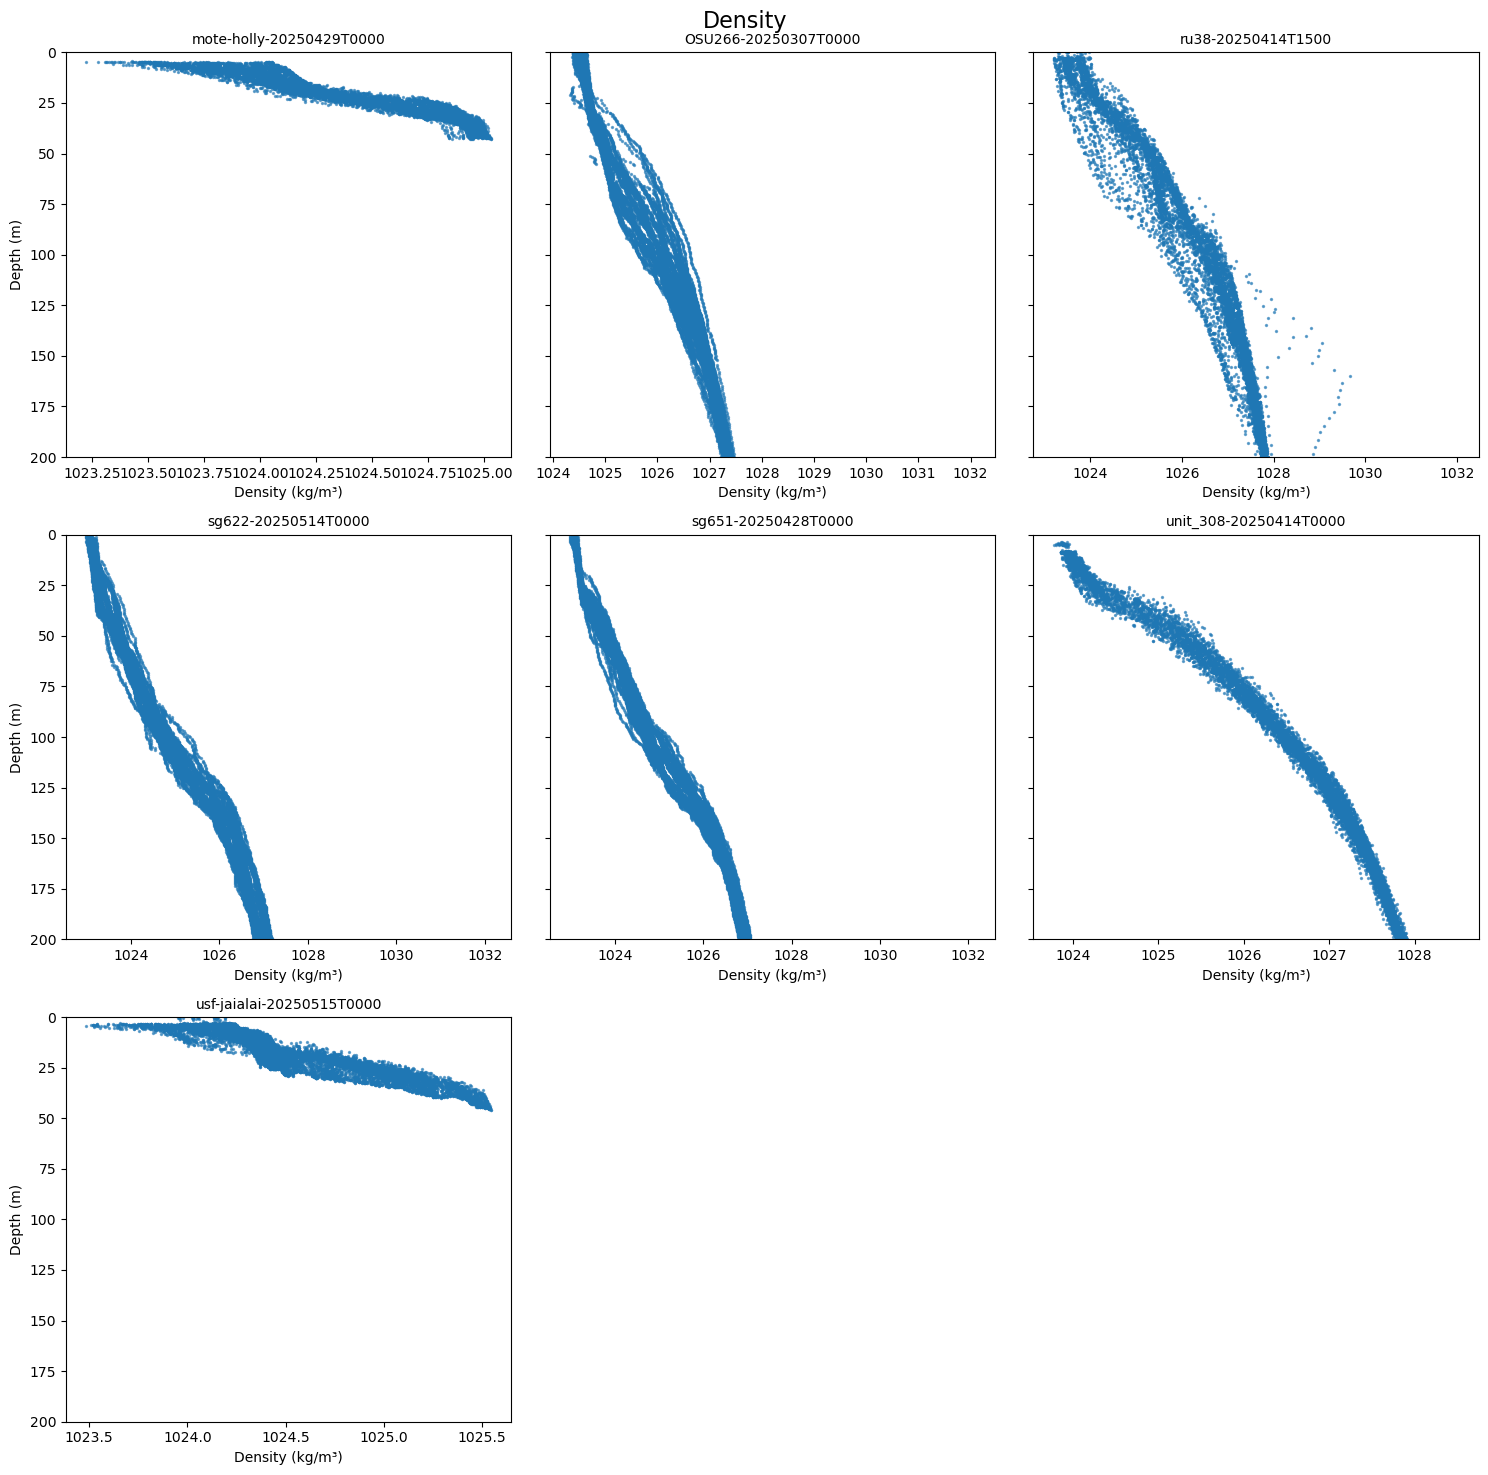

In [9]:
# Ensure time is datetime if needed
gdf['time'] = pd.to_datetime(gdf['time'])

# Get list of unique gliders
gliders = gdf['glider'].unique()
n_gliders = len(gliders)

# Set up subplots: use a square layout (adjust if needed)
cols = 3  # number of columns in the subplot grid
rows = (n_gliders + cols - 1) // cols  # compute rows needed

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), sharey=True)
axes = axes.flatten()  # make axes iterable even if 1D

# Loop through each glider and plot temperature vs depth
for i, glider in enumerate(gliders):
    ax = axes[i]
    glider_df = gdf[gdf['glider'] == glider]
    glider_df = glider_df.sort_values(by='depth')
    ax.scatter(glider_df['temperature'], glider_df['depth'], s=2, alpha=0.6)
    ax.set_title(glider, fontsize=10)
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylim(200,0)  # Depth increases downward
    
    if i % cols == 0:
        ax.set_ylabel("Depth (m)")

# Remove any unused subplots
for j in range(n_gliders, len(axes)):
    fig.delaxes(axes[j])
fig.suptitle("Temperature", fontsize=16)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), sharey=True)
axes = axes.flatten() 
# Loop through each glider and plot salinity vs depth
for i, glider in enumerate(gliders):
    ax = axes[i]
    glider_df = gdf[gdf['glider'] == glider]
    glider_df = glider_df.sort_values(by='depth')
    ax.scatter(glider_df['salinity'], glider_df['depth'], s=2, alpha=0.6)
    ax.set_title(glider, fontsize=10)
    ax.set_xlabel("Salinity")
    ax.set_ylim(200,0)  # Depth increases downward
    
    if i % cols == 0:
        ax.set_ylabel("Depth (m)")

# Remove any unused subplots
for j in range(n_gliders, len(axes)):
    fig.delaxes(axes[j])
fig.suptitle("Salinity", fontsize=16)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), sharey=True)
axes = axes.flatten() 
# Loop through each glider and plot density vs depth
for i, glider in enumerate(gliders):
    ax = axes[i]
    glider_df = gdf[gdf['glider'] == glider]
    glider_df = glider_df.sort_values(by='depth')
    ax.scatter(glider_df['density'], glider_df['depth'], s=2, alpha=0.6)
    ax.set_title(glider, fontsize=10)
    ax.set_xlabel("Density (kg/m³)")
    ax.set_ylim(200,0)  # Depth increases downward
    
    if i % cols == 0:
        ax.set_ylabel("Depth (m)")

# Remove any unused subplots
for j in range(n_gliders, len(axes)):
    fig.delaxes(axes[j])
fig.suptitle("Density", fontsize=16)
plt.tight_layout()
plt.show()
